In [1]:
# Import du jeu de donnée
import pandas as pd
import numpy as np

# copy on write

df = pd.read_csv('fr.openfoodfacts.org.products.csv',sep = '\t',low_memory=False)
# On enlève les colonnes avec moins de 10% de valeurs présentes
df2_under_10 = df.dropna(thresh=0.2*df.shape[0], axis=1)
# On retire les doublons pour la catégorie code et on garde le premier
df2_under_10 = df2_under_10.drop_duplicates(subset='code', keep='first')
# Les pnns_groups_1 regroupe les différentes catégories de produits, cependant tout n'est pas orthographié de la même manière
df3_pnns = df2_under_10.copy()
# Nettoyage des valeurs de pnns_groups_1, enlever les - et mettre en majuscule, remplacer Unknown par NaN
df3_pnns['pnns_groups_1'] = df3_pnns['pnns_groups_1'].str.replace('-',' ').str.capitalize().replace('Unknown',np.nan)

Nous allons réaliser des box plots en fonction des data que nous avons et par catégorie pour voir si l'on peut prédire le jeu de donnée. A en juger par la matrice de missing no. Une bonne moitié d'entre eux sont présent malgré la présence des _100g. Peut être qu'une méthode de regression logistique pourrait fonctionner. On va réaliser quelques analyses complémentaires pour voir à l'oeil s'il y a quelques variations visuellement intéressantes.

In [2]:
# Se débarasser des valeurs que l'on utilisera pas pour notre analyse (J'ai déjà réalisé le boxplot avec df3_pnns avant, et certaines données ne servait à rien, j'ai donc décidé d'itérer les graphiques qui viendront après avec df4 et df5)
df4_drop = df3_pnns.drop(columns=['url', 'creator', 'created_t', 'created_datetime',
       'last_modified_t', 'last_modified_datetime', 'product_name', 'quantity', 'packaging', 'packaging_tags', 'brands',
       'brands_tags', 'categories', 'categories_tags', 'categories_fr', 'countries',
       'countries_tags', 'countries_fr', 'ingredients_text', 'serving_size',
       'additives_n', 'additives', 'additives_tags', 'additives_fr',
       'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'nutrition_grade_fr', 'pnns_groups_2', 'states', 'states_tags', 'states_fr',
       'main_category', 'main_category_fr', 'image_url', 'image_small_url', 'nutrition-score-uk_100g'])

In [3]:
import numpy as np

df5_IQR = df4_drop.copy()

for category in df5_IQR['pnns_groups_1'].unique():
    category_data = df5_IQR[df5_IQR['pnns_groups_1'] == category]
    for col in df5_IQR.select_dtypes(include=['float64']).columns:
        Q1 = category_data[col].quantile(0.25)
        Q3 = category_data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Remplacement des valeurs aberrantes par NaN pour la catégorie et la colonne courantes
        df5_IQR.loc[(df5_IQR['pnns_groups_1'] == category) & 
                    ((df5_IQR[col] < lower_bound) | (df5_IQR[col] > upper_bound)), col] = np.nan

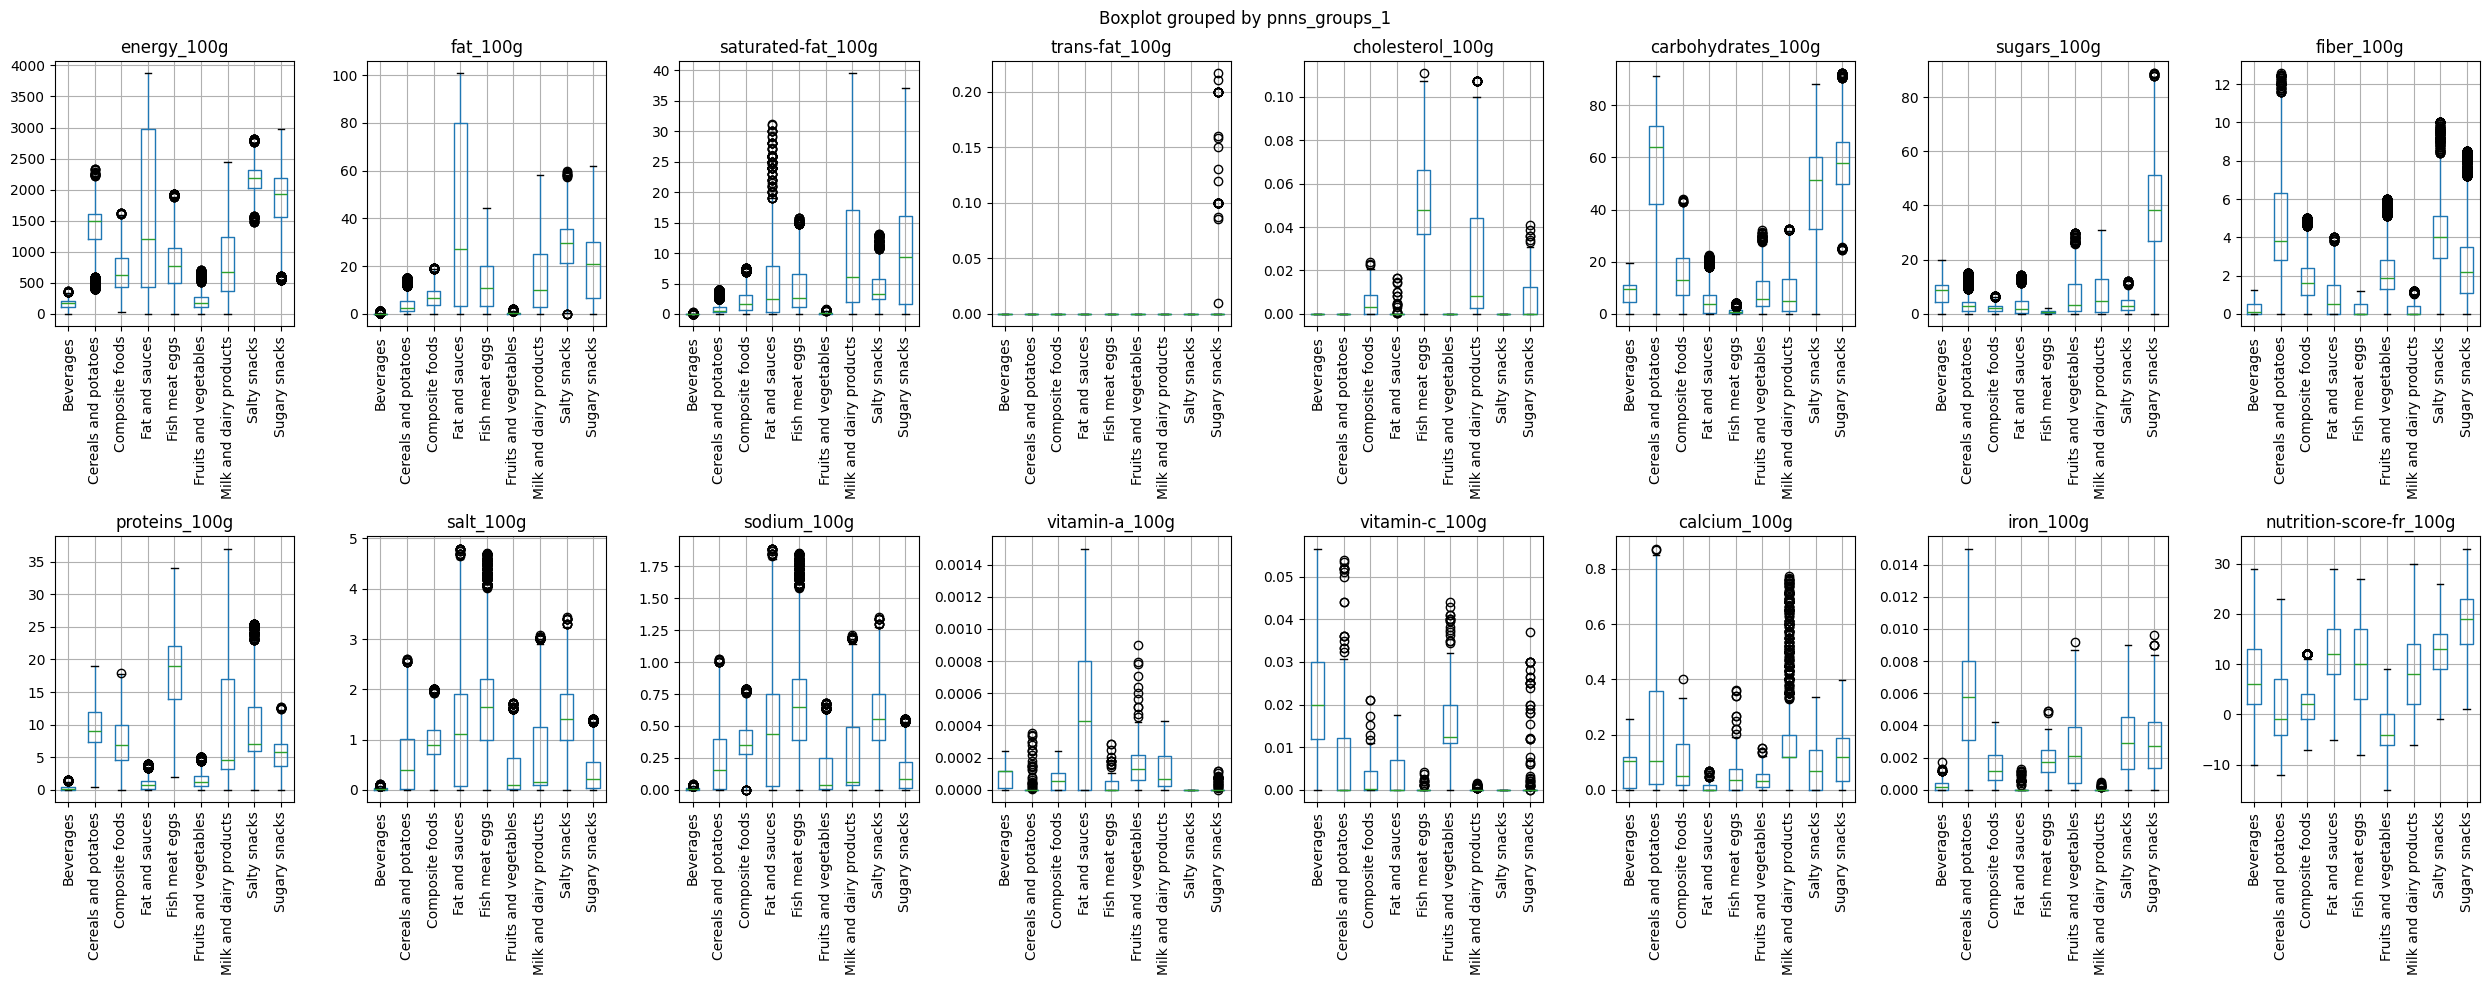

In [4]:
import matplotlib.pyplot as plt
# On refait les boxplots avec df5_IQR
num_cols = 8
num_rows = int(np.ceil(len(df5_IQR.select_dtypes(include=['float64']).columns) / num_cols))

fig, axes = plt.subplots(num_rows, num_cols, figsize=(25, 5*num_rows))
axes = axes.flatten()

for i, col in enumerate(df5_IQR.select_dtypes(include=['float64']).columns):
    df5_IQR.boxplot(column=col, by='pnns_groups_1', ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', labelrotation=90)

for j in range(i+1, num_cols*num_rows):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()    

Les outliers ont été efficacement réduits en utilisant l'IQR par groupe PNNS, c'est plus propre pour réaliser une analyse.
Les groupes de energy_100g, fat_100g, et sugars_100g varient significativement entre les catégories, ce qui permet d'observer des différences claires entre les groupes.

In [5]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5)

In [6]:
df6_kmeans = df5_IQR.copy()
df6_kmeans = df6_kmeans.dropna()

# On ne garde que les colonnes numériques
df6_kmeans = df6_kmeans.select_dtypes(include=['float64'])

kmeans.fit(df6_kmeans)


KMeans(n_clusters=5)

In [7]:
labels = kmeans.predict(df6_kmeans)
labels

array([0, 0, 3, 3, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 3, 3, 4, 0, 3, 0, 3, 1,
       1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 3, 2, 1, 2, 2, 0,
       0, 2, 0, 0, 4, 2, 1, 1, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 3, 0, 0,
       1, 1, 1, 4, 2, 0, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 3, 0, 0, 0, 4, 1,
       1, 1, 1, 1, 1, 0, 3, 1, 1, 0, 3, 0, 1, 3, 3, 0, 2, 0, 0, 3, 2, 3,
       0, 0, 4, 1, 3, 0, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 3,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 4, 0, 0, 0, 3, 2, 0, 0, 0,
       3, 2, 2, 2, 3, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 2, 1, 1, 1, 3, 3, 1, 1, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3,
       2, 0, 0, 2, 0, 1, 0, 4, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 3, 3, 2, 3,
       2, 3, 3, 2, 2, 0, 0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 2, 2, 1, 2, 0, 2, 2, 3, 0, 2, 2, 0, 2, 1, 2, 2, 0, 2, 1, 3, 3,
       0, 0, 2, 0, 1, 0, 1, 0, 1, 3, 0, 4, 4, 0, 2, 3, 0, 1, 2, 2, 0, 0,
       2, 3, 1, 1, 1, 1, 0, 2, 0, 0, 0, 0, 3, 0, 3,

In [8]:
centroids = kmeans.cluster_centers_
centroids

array([[ 2.66816312e+02,  1.52240426e+00,  6.01121277e-01,
        -4.33680869e-19,  6.04014184e-03,  9.09678723e+00,
         6.72427660e+00,  5.72685816e-01,  3.50395745e+00,
         5.08459220e-01,  2.00157532e-01,  4.92680851e-05,
         3.20817021e-03,  5.31510638e-02,  2.83489362e-04,
         2.22695035e+00],
       [ 2.05589011e+03,  2.52186813e+01,  1.13483516e+01,
         2.67692308e-03,  8.91753846e-03,  6.38956044e+01,
         3.57080220e+01,  2.87493407e+00,  6.00439560e+00,
         7.12629890e-01,  2.80479780e-01,  7.58241758e-06,
         3.61890110e-04,  5.86961538e-02,  2.08423077e-03,
         2.00000000e+01],
       [ 1.55990426e+03,  1.19208404e+01,  5.02719149e+00,
         3.23404255e-03,  2.12694681e-02,  5.50412766e+01,
         8.83510638e+00,  2.50840426e+00,  1.09244681e+01,
         8.12731064e-01,  3.20023723e-01,  5.54138298e-05,
         1.46489362e-04,  1.20946596e-01,  2.08235336e-03,
         6.24468085e+00],
       [ 8.96909091e+02,  8.55340909e

In [9]:
# import scaler and pca
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df6_kmeans)

pca = PCA(n_components=6)
pca.fit(X_scaled)

PCA(n_components=6)

In [10]:
pca.explained_variance_ratio_.cumsum()

array([0.26984545, 0.4958173 , 0.61854123, 0.72183646, 0.78460965,
       0.84464365])

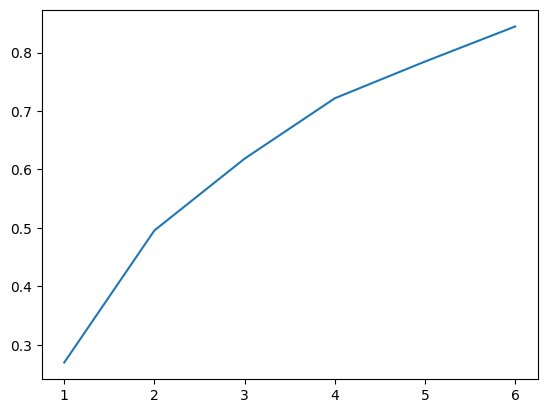

In [11]:
import matplotlib.pyplot as plt

plt.plot(range(1,7), pca.explained_variance_ratio_.cumsum()) # 6 car on a 6 composantes
plt.xlabel = "n_components"
plt.ylabel = "% of variance"

In [12]:
X_proj = pca.transform(X_scaled)
X_proj[:10]

array([[-1.5571438 , -0.64432342,  0.19871328,  0.00479558,  0.39445131,
        -0.58529796],
       [-1.83577356, -0.85847719, -0.67656343,  1.04357351, -0.00550577,
        -0.04969782],
       [ 0.16113547, -1.45347907, -0.32313188,  0.34170376, -0.1556346 ,
         0.22699321],
       [-0.67869946, -1.12408528, -0.1166356 , -0.22495156,  0.33012118,
        -0.40161581],
       [-2.02636642, -0.52770488,  0.70283059, -0.47468816,  0.58613197,
        -0.86686857],
       [ 3.1463502 ,  1.29796329, -0.27623584, -0.07966801, -0.5661457 ,
         0.19580495],
       [-2.29071708, -0.86982315,  0.17952375,  0.42225643, -0.95646843,
         1.07068006],
       [ 3.30266981,  1.3268616 ,  2.14245133, -0.35769877, -0.22147162,
        -0.45817812],
       [ 3.12351441,  1.25415659,  2.20220897, -0.23472301, -0.23177249,
        -0.48121094],
       [ 2.50918046,  2.18916211,  1.6960388 ,  0.01561869, -0.27150058,
        -0.32945101]])

In [13]:
X_proj = pd.DataFrame(X_proj, columns = ["F1", "F2", "F3", "F4", "F5", "F6"])
X_proj[:10]

,F1,F2,F3,F4,F5,F6
0,-1.557144,-0.644323,0.198713,0.004796,0.394451,-0.585298
1,-1.835774,-0.858477,-0.676563,1.043574,-0.005506,-0.049698
2,0.161135,-1.453479,-0.323132,0.341704,-0.155635,0.226993
3,-0.678699,-1.124085,-0.116636,-0.224952,0.330121,-0.401616
4,-2.026366,-0.527705,0.702831,-0.474688,0.586132,-0.866869
5,3.146350,1.297963,-0.276236,-0.079668,-0.566146,0.195805
6,-2.290717,-0.869823,0.179524,0.422256,-0.956468,1.070680
7,3.302670,1.326862,2.142451,-0.357699,-0.221472,-0.458178
8,3.123514,1.254157,2.202209,-0.234723,-0.231772,-0.481211
9,2.509180,2.189162,1.696039,0.015619,-0.271501,-0.329451


In [14]:
centroids_scaled = scaler.fit_transform(centroids)
centroids_scaled

array([[-1.46791235, -1.00080079, -1.27651474, -0.81051849, -0.83455544,
        -1.30179497, -0.71548193, -1.83985583, -1.59763312, -0.88554026,
        -0.88548413,  0.94936022,  1.94588548, -1.15788466, -1.63393236,
        -1.10736403],
       [ 0.70798072,  0.25339963,  1.27732869,  1.02479555, -0.39607702,
         1.37269792,  1.87247556,  0.75202612, -0.73785045, -0.09814205,
        -0.09839401, -1.07282737, -0.52584595, -0.94245478,  0.4448386 ,
         1.49907272],
       [ 0.10475676, -0.45043066, -0.22475629,  1.40675991,  1.486199  ,
         0.94055654, -0.52700602,  0.33938513,  0.95393029,  0.287905  ,
         0.28910319,  1.24749263, -0.71290161,  1.47601008,  0.44267133,
        -0.51815955],
       [-0.70158593, -0.62866262, -0.7999913 , -0.81051849,  0.84822791,
        -0.61721631, -0.81785728, -0.19766945,  0.83009173,  1.7409508 ,
         1.74045957,  0.05434839, -0.05459989,  0.75802495, -0.53724267,
        -0.72735716],
       [ 1.35676079,  1.82649444,  1

In [15]:
centroids_proj = pca.transform(centroids_scaled)
centroids_proj = pd.DataFrame(centroids_proj, 
                              columns = ["F1", "F2", "F3", "F4", "F5", "F6"], 
                              index=["cluster_0", "cluster_1", "cluster_2", "cluster_3", "cluster_4"])
centroids_proj

,F1,F2,F3,F4,F5,F6
cluster_0,-4.129307,-1.014411,2.025557,0.591207,-1.234759,0.230243
cluster_1,1.902331,2.651539,0.874270,1.092967,0.677409,0.194969
cluster_2,0.921686,-1.284829,-1.111181,-1.526772,1.355265,0.951814
cluster_3,-0.484385,-2.531446,-1.893751,0.674607,-0.278278,-0.561672
cluster_4,1.789675,2.179147,0.105105,-0.832009,-0.519636,-0.815354


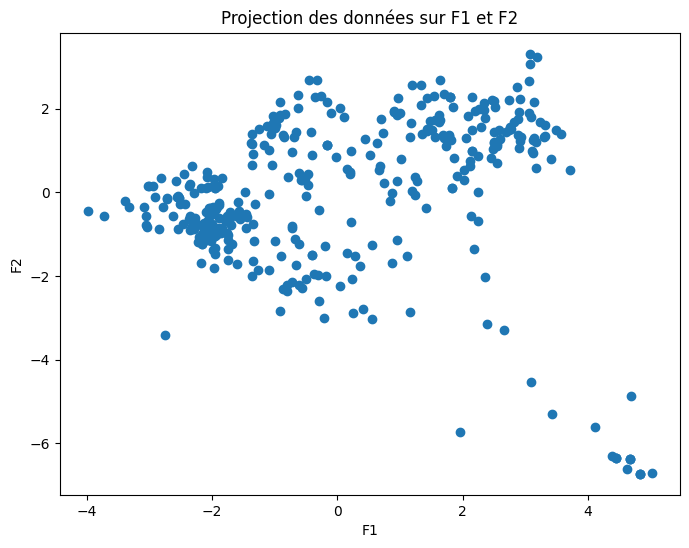

In [16]:
# Graphique de base des données projetées
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(X_proj.iloc[:, 0], X_proj.iloc[:, 1])
ax.set_xlabel('F1')
ax.set_ylabel('F2')
ax.set_title('Projection des données sur F1 et F2')
plt.show()

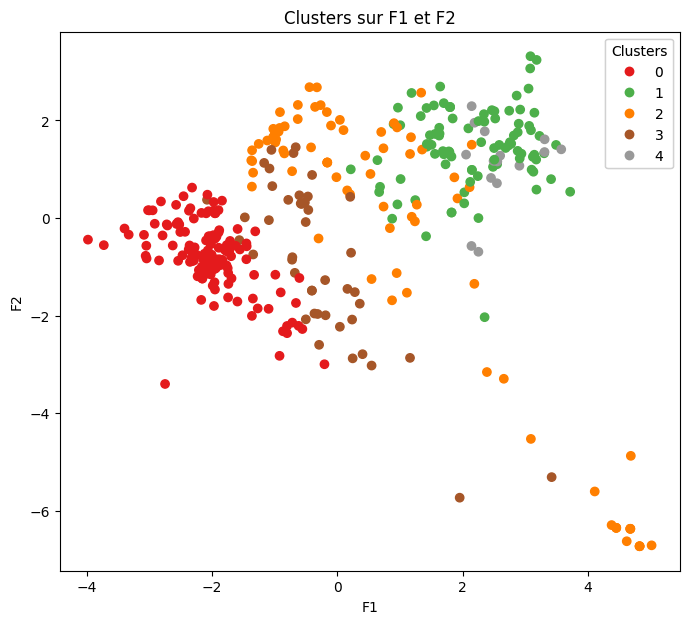

In [17]:
# Graphique des données projetées avec clusters colorés
fig, ax = plt.subplots(figsize=(8, 7))
scatter = ax.scatter(X_proj.iloc[:, 0], X_proj.iloc[:, 1], c=labels, cmap="Set1")
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)
ax.set_xlabel("F1")
ax.set_ylabel("F2")
ax.set_title('Clusters sur F1 et F2')
plt.show()

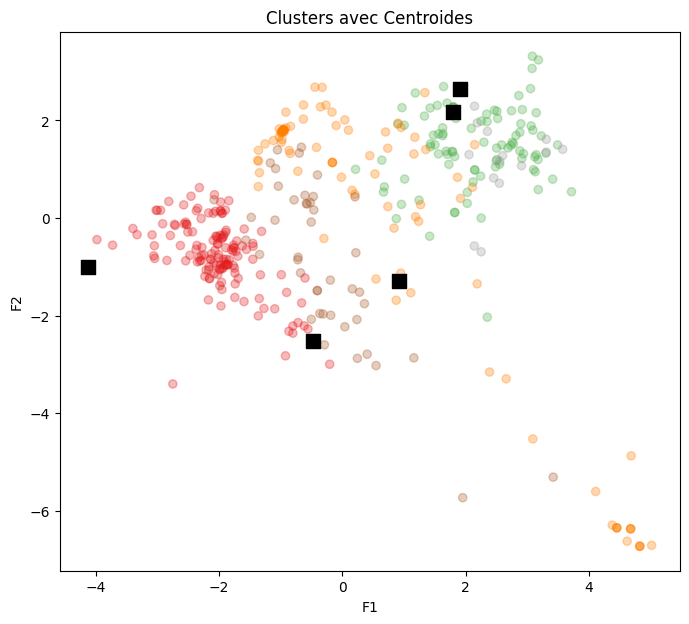

In [18]:
# Graphique des données projetées avec clusters et centroides
fig, ax = plt.subplots(figsize=(8, 7))
ax.scatter(X_proj.iloc[:, 0], X_proj.iloc[:, 1], c=labels, cmap="Set1", alpha=0.3)
ax.scatter(centroids_proj.iloc[:, 0], centroids_proj.iloc[:, 1], marker="s", c="black", s=100)
ax.set_xlabel("F1")
ax.set_ylabel("F2")
ax.set_title('Clusters avec Centroides')
plt.show()

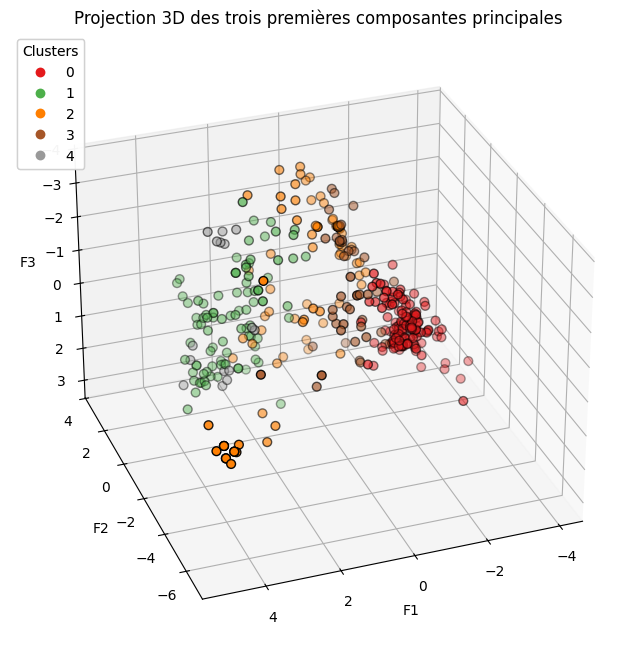

In [19]:
# Graphique 3D des trois premières composantes principales
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)
scatter = ax.scatter(X_proj.iloc[:, 0], X_proj.iloc[:, 1], X_proj.iloc[:, 2], c=labels, cmap=plt.cm.Set1, edgecolor="k", s=40)
ax.set_xlabel("F1")
ax.set_ylabel("F2")
ax.set_zlabel("F3")
ax.set_title('Projection 3D des trois premières composantes principales')
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters", loc='upper left')
ax.add_artist(legend1)
plt.show()

In [20]:
import plotly.express as px
from sklearn.cluster import AgglomerativeClustering

# Création du graphique 3D
fig = px.scatter_3d(
    x=X_proj.iloc[:, 0],
    y=X_proj.iloc[:, 1],
    z=X_proj.iloc[:, 2],
    color=labels,
    labels={'x': 'F1', 'y': 'F2', 'z': 'F3', 'color': 'Cluster'},
    title='Projection 3D des trois premières composantes principales',
    color_continuous_scale=px.colors.sequential.Viridis
)

# Ajout des centroides
fig.add_scatter3d(
    x=centroids_proj.iloc[:, 0],
    y=centroids_proj.iloc[:, 1],
    z=centroids_proj.iloc[:, 2],
    mode='markers',
    marker=dict(size=10, color='black', symbol='x'),
    name='Centroides'
)

# Personnalisation des axes et des légendes
fig.update_layout(
    scene=dict(
        xaxis=dict(title='F1'),
        yaxis=dict(title='F2'),
        zaxis=dict(title='F3')
    ),
    legend=dict(
        title='Clusters',
        itemsizing='constant'
    )
)

# Affichage du graphique
fig.show()


Je vois que j'ai bien créé de jolie graphiques 3d ou j'ai clusturisé un peu comme je l'imaginais les données. Mais je manque clairement de maitrise pour savoir quoi en faire. Je vais donc ne pas me permettre de surinterpréter. En revanche j'ai demandé un petit tableau récapitulatif à un ami robot qui répond à toutes mes questions sous réserves de bien les formuler...

In [21]:
import plotly.graph_objects as go

# Création du tableau des coefficients des composantes principales
components_df = pd.DataFrame(
    np.round(pca.components_, 4), 
    columns=df6_kmeans.columns, 
    index=["F1", "F2", "F3", "F4", "F5", "F6"]
)

# Formatage des valeurs pour mettre en gras celles >= |0.40|
def format_value(value):
    if abs(value) >= 0.4:
        return f'<b>{value}</b>'
    else:
        return f'{value}'

formatted_components_df = components_df.applymap(format_value)

# Affichage du tableau des coefficients
fig = go.Figure(data=[go.Table(
    header=dict(values=['Composante'] + list(components_df.columns),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[formatted_components_df.index] + [formatted_components_df[col] for col in formatted_components_df.columns],
               fill_color='lavender',
               align='left',
               format=['']*len(formatted_components_df.columns))
)])

fig.update_layout(title='Impact des variables sur les composantes principales')
fig.show()


C:\Users\Richard\AppData\Local\Temp\ipykernel_20284\4175595921.py:17: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



En surlignant en gras tout ce qui est plus important que 0,4 comme coefficient d'impact des variables sur nos composantes, on peut clairement voir les effets suivants :

* Les variables les plus influentes sur F1 sont l'énergie et fat et saturated fat, ce qui présage d'une sensibilité au macronutriments à haute teneur énergétique (oui je sais que j'ai dis que j'avais du mal à interprété les données car pas spécialiste, mais j'ai eu un master en nutrition santé ... C'était il y a longtemps).

* Pour F2 en revanche on enregistre une légère influence négative du cholestérol et positive des carbohydrates (gras et sucres) ça tombe bien, un produit haut en glucide (cérales et fruits) et en général peu élevé en cholestérol mais plutôt en phytostérole (pas indiqué dans notre jeu de donnée)

* Pour F3 on est sur une dualité sucre et sel, ce qui n'est pas étonnant car on ne fait pas souvent dans le sucré salé dans l'alimentation humaine

* F4 Pareillement on semble avoir une opposition protéines et sels (négativement prots positivement sels) les produits comme la viande maigre et les légumineuses par exemple sont riches en prots, moins en sel.

* F5 c'est intéressant on enregistre parmi les plus fortes influences positives sur les acide gras trans, et une opposition net bien que moindre de la vitamine C. Dans la littérature on retrouve des acides gras trans surtout dans des produits industriels (comme la friture, la patisseries et les biscuits) là ou la vitamine C est plutôt présente dans les fruits et légumes frais. C'est un beau paramètre.

* Que F6 montre l'inverse me pose un peu question, peut être qu'on arrive au limite de l'analyse, je n'en sais rien.
